# Sentinel-1から浸水確率ラスターデータの生成

GPUを設定してください。
「ランタイム」⇒「ランタイムのタイプを変更」より行えます。<br>
詳しくは https://research.google.com/colaboratory/faq.html#gpu-utilization

広域の場合、実行には数分かかります。

In [ ]:
# @title Google Earth Engineの認証
import ee
ee.Authenticate()
ee.Initialize()

In [ ]:
# @title Googleドライブの準備
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title パラメータの設定
casename = "kurume-r2-rev2"

date = "2020-07-10"


In [ ]:
# @title 詳細設定用パラメータ（基本的には操作不要）

polmode = "vv/vh"
enable_savefig = False # 図をGoogleドライブに保存する？

# 機械学習用パラメータ
# median = -17.233137786388397
# std_dev = 5.842539646934703

## マスク＆データ拡張版
median = -14.373820960521698
std_dev = 6.312272332690032

# デバッグ用出力
global globalflag_debug

# 保存先
path_home = "/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/"
path_case = path_home + casename + "/"
path_model = path_home+"models/"
file_boundary = path_case+"boundary.json"
file_bbox = path_case + "boundbox.npy"
file_prb = path_case + "floodprb.pt"
file_fldbbox = path_case + "floodprb_bbox.npy"

## 各種読み込み

In [ ]:
!pip install rasterio pyproj
!pip install geojson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 42.4 MB/s eta 0:00:00


In [ ]:
# @title 主要ライブラリインポート
import math
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter

import pyproj
import rasterio

from datetime import datetime, timedelta

import os
import zipfile
import requests
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision.transforms import Lambda
from torch import nn
import torch.nn.functional as F

In [ ]:
# @title 基本的な関数

# WGS84 (EPSG:4326) to JGD2011(EPSG:6668)
transformer_wgs84_jgd2011 = pyproj.Transformer.from_crs("epsg:4326", "epsg:6668", always_xy=True)
convert_wgs84_jgd2011 = transformer_wgs84_jgd2011.transform
#print(convert_wgs84_jgd2011(130.2,35))

def coordinates_to_rect(coordinates):
  #coordinates = coordinates[0]

  lon_min = min(coordinates, key=lambda x: x[0])[0]
  lon_max = max(coordinates, key=lambda x: x[0])[0]
  lat_min = min(coordinates, key=lambda x: x[1])[1]
  lat_max = max(coordinates, key=lambda x: x[1])[1]
  # rasterio bounds tuple (left, bottom, right, top)
  # https://rasterio.readthedocs.io/en/stable/api/rasterio.coords.html
  return (lon_min, lat_min, lon_max, lat_max)

In [ ]:
# @title 設定ファイルの読み込み
boundbox = np.load(file_bbox)

############## old code
#import geojson

#boundary = []
#with open(file_boundary) as ifile:
#  txt = ifile.read()
#  print(txt)
#  tmp = geojson.loads(txt)
#  for vv in tmp:
#    for pp in vv["coordinates"]:
#      boundary.extend(pp)
#print(boundary)
#boundbox = coordinates_to_rect(boundary)

print(boundbox)
center = {
    "lon": (boundbox[0]+boundbox[2])*0.5,
    "lat": (boundbox[1]+boundbox[3])*0.5
}
print(center)

[130.40008279  33.22512157 130.6999996   33.36663976]
{'lon': 130.55004119310746, 'lat': 33.29588066105276}


## SAR画像による水面推定＆浸水深推定

In [ ]:
# @title 衛星データ用関数
from io import BytesIO
from rasterio.io import MemoryFile

def find_sar_info(lon, lat, date):
  if "globalflag_debug" in globals():
    print(f"Acquiring the SAR info for the date {date}.")

  point = ee.Geometry.Point(lon, lat)

  if isinstance(date, str):
    date1 = datetime.strptime(date, '%Y-%m-%d')
  elif isinstance(date, datetime):
    date1 = date
  else:
    raise(f"Unknown date type {type(date)}")
  date2 = date1 + timedelta(days=1)
  if "globalflag_debug" in globals():
    print(date1.strftime('%Y-%m-%d'), date2.strftime('%Y-%m-%d'))

  # 画像コレクションの取得（Sentinel-1を指定）
  collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
                  .filterBounds(point) \
                  .filterDate(date1, date2) # 期間を指定

  if collection.size().getInfo() == 0:
    print(meta['note'], "is not found.", date1, "-", date2)

  # コレクションから最初の画像を取得
  image = ee.Image(collection.first())

  #print(collection.size().getInfo()) # for debug

  actual_date = ee.Date(image.get("system:time_start")).format('YYYY-MM-dd').getInfo()

  # 画像のメタデータを取得
  info = image.getInfo()
  return image, info

def get_twice_orbit_sars(current_date, lon, lat, orbit_date=12):
  if isinstance(current_date, str):
    current_date = datetime.strptime(current_date, "%Y-%m-%d")

  last_date = current_date - timedelta(days=orbit_date)

  current_orbit = find_sar_info(lon, lat, current_date)
  last_orbit = find_sar_info(lon, lat, last_date)
  return {"current": current_orbit, "last": last_orbit}

def get_orbit_sars(current_date, lon, lat, orbit_date=12, history_length=4):
  if isinstance(current_date, str):
    current_date = datetime.strptime(current_date, "%Y-%m-%d")

  current_orbit = find_sar_info(lon, lat, current_date)

  last_date = current_date
  orbit_history = []
  for i in range(history_length):
    last_date = last_date - timedelta(days=orbit_date)
    orbit_history.append(find_sar_info(lon, lat, last_date))

  return {"current": current_orbit, "history": orbit_history}


def meters_to_degrees(meters, lat):
  width = meters / (111319.44 * math.cos(math.radians(lat)))
  height = meters / 111319.44
  return (width, height)


def create_coordinates(start_lon, end_lon, start_lat, end_lat, shape):
  lon_coords = np.linspace(start_lon, end_lon, shape[1])
  lat_coords = np.linspace(start_lat, end_lat, shape[0])

  lon_grid, lat_grid = np.meshgrid(lon_coords, lat_coords)

  grid = np.dstack((lon_grid.flatten(), lat_grid.flatten()))[0]
  return grid

def concat_tiles(tiles, regions):
  revisions = int(math.sqrt(len(tiles)))
  known_coords, known_image_data = get_coords_knowndata(tiles, regions)
  start_lon, end_lat = regions[0].getInfo()['coordinates'][0][0]
  end_lon, start_lat = regions[-1].getInfo()['coordinates'][0][2]
  desired_latlon_grid = create_coordinates(start_lon, end_lon, start_lat, end_lat, (512*revisions, 512*revisions))
  image = scipy.interpolate.griddata(known_coords, known_image_data, desired_latlon_grid, method='nearest')
  return image.reshape(512*revisions, 512*revisions), (start_lon, end_lat, end_lon, start_lat)

def get_coords_knowndata(tiles, regions):
  known_coords = np.empty((0, 2))

  for tile, region in zip(tiles, regions):
    start_lon, end_lat = region.getInfo()['coordinates'][0][0]
    end_lon, start_lat = region.getInfo()['coordinates'][0][2]

    coords = create_coordinates(start_lon, end_lon, start_lat, end_lat, tile.shape)
    known_coords = np.concatenate((known_coords, coords))
  known_image_data = np.concatenate([tile.ravel() for tile in tiles])
  return known_coords, known_image_data

def get_sar_image(url):
  print(url)
  response = requests.get(url)
  zipfile_obj = zipfile.ZipFile(BytesIO(response.content))

  # zipファイル内のtifファイル名を取得
  tif_vv_filename = [filename for filename in zipfile_obj.namelist() if filename.endswith('VV.tif')][0]
  tif_vh_filename = [filename for filename in zipfile_obj.namelist() if filename.endswith('VH.tif')][0]

  # tifファイルを読み込む
  with zipfile_obj.open(tif_vh_filename) as tif_file:
      with MemoryFile(tif_file) as memfile:
          with memfile.open() as dataset:
              vh_array = dataset.read(1)
              bounds = dataset.bounds
              crs = dataset.crs

  with zipfile_obj.open(tif_vv_filename) as tif_file:
      with MemoryFile(tif_file) as memfile:
          with memfile.open() as dataset:
              vv_array = dataset.read(1)
  return vh_array, vv_array, bounds, crs

def get_sar_tiles(image, regions):
  tiles_vh = []
  tiles_vv = []
  region_info = []

  for i, region in enumerate(regions):
    url = image.getDownloadUrl({
      'scale': 10,  # resolution in meters
      'region': region  # download the region at the specified point
    })

    vh_array, vv_array, bounds, crs = get_sar_image(url)
    region_info.append((bounds, crs))
    tiles_vh.append(vh_array)
    tiles_vv.append(vh_array)

  return tiles_vh, tiles_vv, region_info

def get_aerial_tiles(image, regions):
  tiles_vh = []
  tiles_vv = []
  region_info = []

  for i, region in enumerate(regions):
    url = image.getDownloadUrl({
      'scale': 10,  # resolution in meters
      'region': region  # download the region at the specified point
    })

    vh_array, vv_array, bounds, crs = get_sar_image(url)
    region_info.append((bounds, crs))
    tiles_vh.append(vh_array)
    tiles_vv.append(vh_array)

  return tiles_vh, tiles_vv, region_info

def generate_regions_from_boundbox(info, boundbox,scale=10):
    # Bounds of the image
    image_bounds = ee.Geometry(info['properties']['system:footprint'])

    # Width and height of the regions in degrees
    # Approximate conversion from meters to degrees at the center
    tile_width, tile_height = meters_to_degrees(scale*512, (boundbox[1]+boundbox[3])*0.5)

    lons = np.arange(boundbox[0], boundbox[2]+tile_width, tile_width)
    lats = np.arange(boundbox[1], boundbox[3]+tile_height, tile_height)
    # List to store the regions
    regions = []

    for lon in lons:
        for lat in lats:
            # Calculate the bounds of the region
            region_coords = [[lon, lat],
                             [lon + tile_width, lat],
                             [lon + tile_width, lat + tile_height],
                             [lon, lat + tile_height]]

            # Create a Geometry.Polygon object
            region = ee.Geometry.Polygon(region_coords)

            # Check if the region is completely within the image bounds
            if True:#image_bounds.contains(region).getInfo():
                regions.append(region)
            else:
                print(f"Out Bounds {region} {image_bounds}")

    return regions


def get_big_image_from_orbit_boundbox(orbit, boundbox, kind="SAR"):
  image, info = orbit
  regions = generate_regions_from_boundbox(info, boundbox)

  if kind=="SAR":
    tiles_vh, tiles_vv, region_info = get_sar_tiles(image, regions)
  else:
    tiles_vh, tiles_vv, region_info = get_aerial_tiles(image, regions)
  #print(f"# of tiles: {len(tiles_vh)}")

  big_vh, boundbox_new = concat_tiles(tiles_vh, regions)
  big_vv, boundbox_new = concat_tiles(tiles_vv, regions)


  # plt.figure(figsize=(8, 8))
  # plt.imshow(big_vh)

  # plt.figure(figsize=(8, 8))
  # plt.imshow(big_vv)
  return big_vh, big_vv, boundbox_new

In [ ]:
# @title 衛星データ初期処理
orbits = get_orbit_sars(date, center["lon"], center["lat"])

num_skip_recently_data = 1 # 直近のデータは1つ飛ばす
num_data = len(orbits["history"]) - num_skip_recently_data

current_orbit = orbits["current"]
big_vh, big_vv, boundbox_new = get_big_image_from_orbit_boundbox(current_orbit, boundbox)
previous_vhs = np.zeros((num_data, *big_vh.shape))
previous_vvs = np.zeros((num_data, *big_vv.shape))
for i in range(num_data):
  previous_vhs[i], previous_vvs[i], boundbox_new = get_big_image_from_orbit_boundbox(orbits["history"][i+num_skip_recently_data], boundbox)

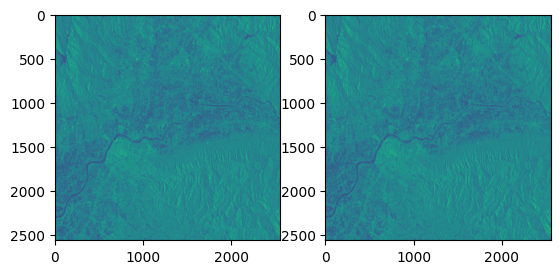

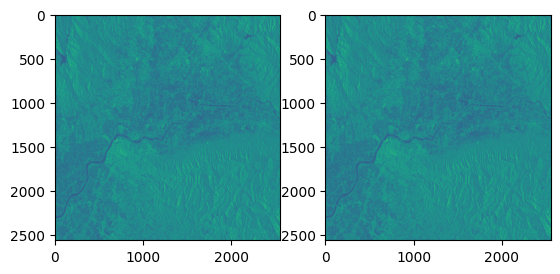

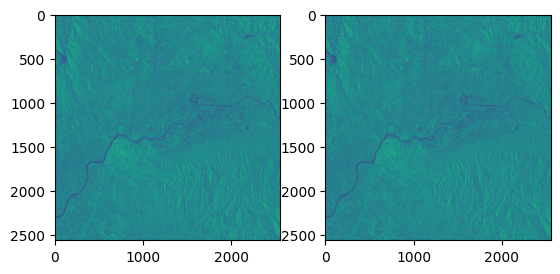

In [ ]:
for i in range(3):
  plt.figure()
  plt.subplot(121)
  plt.imshow(previous_vhs[i])
  plt.subplot(122)
  plt.imshow(previous_vvs[i])

In [ ]:
last_vh, last_vv = previous_vhs.mean(axis=0), previous_vvs.mean(axis=0)

(2560, 2560)


Text(0.5, 1.0, 'Last mean orbit VV')

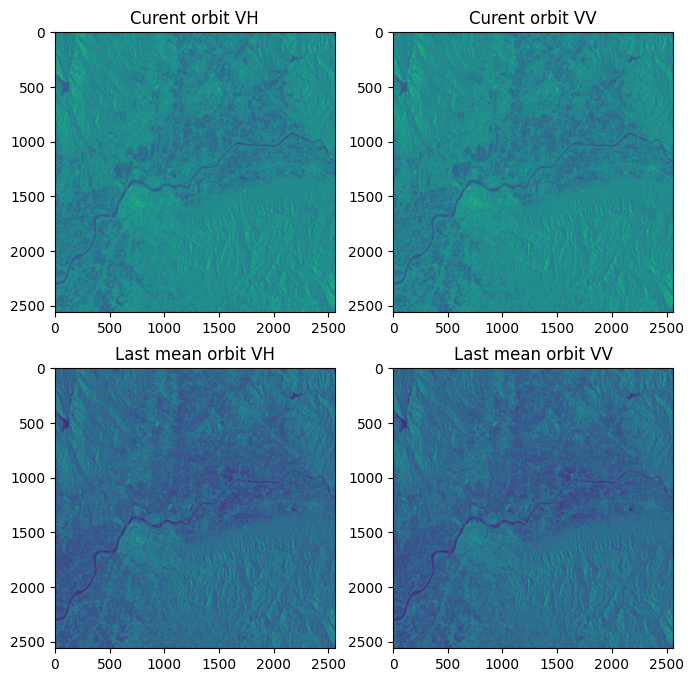

In [ ]:
print(np.shape(big_vh))
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.imshow(big_vh)
plt.title("Curent orbit VH")
plt.subplot(222)
plt.imshow(big_vv)
plt.title("Curent orbit VV")

plt.subplot(223)
plt.imshow(last_vh)
plt.title("Last mean orbit VH")
plt.subplot(224)
plt.imshow(last_vv)
plt.title("Last mean orbit VV")

In [ ]:
# @title 機械学習用関数

def custom_normalize(image, median, std_dev):
    # NumPy配列をPyTorchテンソルに変換
    # image = torch.tensor(image, dtype=torch.float32)

    # 中央値を減算して中央値が0になるようにする
    image = image - median

    # 標準偏差で除算してほとんどのピクセル値が範囲(-1, 1)に収まるようにスケーリングする
    image = image / std_dev

    return image

normalize_transform = Lambda(lambda image: custom_normalize(image, median, 3 * std_dev))


# # If multiple GPUs are available, use DataParallel to utilize them
# if torch.cuda.device_count() > 1:
#   print("Using", torch.cuda.device_count(), "GPUs!")


def inference_with_patches(model, data, transform, max_batch_size=32):
    # Define stride and patch size
    stride = 256
    patch_size = 512

    # Create window for Gaussian weights
    gauss_window = np.zeros((patch_size, patch_size))
    for i in range(patch_size):
        for j in range(patch_size):
            gauss_window[i, j] = np.exp(-((i - patch_size / 2) ** 2 + (j - patch_size / 2) ** 2) / (2.0 * (patch_size / 6) ** 2))
    gauss_window = torch.from_numpy(gauss_window).float()

    # Use GPU if available
    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # model.to(device)
    # gauss_window.to(device)

    # Prepare tensor for storing results and a tensor to count the overlaps
    output = torch.zeros(data.shape[0], 2, *data.shape[2:]) #.to(device)
    counts = torch.zeros(*data.shape) # .to(device)

    # List to store the patches and their indices
    patches = []
    indices = []

    # Slide over the data with stride 256
    for b in range(data.shape[0]):
        for i in range(0, data.shape[2]-stride, stride):
            for j in range(0, data.shape[3]-stride, stride):
                # Extract patch
                patch = data[b:b+1, :, i:i+patch_size, j:j+patch_size]
                patches.append(patch)
                indices.append((b, i, j))

    with torch.no_grad():
        # Iterate over patches with maximum batch size
        l = 0
        for b in range(0, len(patches), max_batch_size):
            # Select batch of patches
            patches_batch = torch.cat(patches[b:b+max_batch_size]).to(device)

            # Inference all patches in the batch at once
            # display(patches_batch.shape)
            patches_out = model(transform(patches_batch))

            # Iterate over the outputs
            for k in range(patches_out.shape[0]):
                # Get the original index of the patch
                b_orig, i, j = indices[b+k]

                # Add Gaussian weights
                patch_out_weighted = patches_out[k:k+1].detach().cpu() * gauss_window #.to(device)

                # Add to output tensor

                output[b_orig:b_orig+1, :, i:i+patch_size, j:j+patch_size] += patch_out_weighted
                counts[b_orig:b_orig+1, :, i:i+patch_size, j:j+patch_size] += gauss_window # .to(device)

    # Normalize by the counts
    output /= counts

    return output


In [ ]:
# @title 機械学習による浸水評価

image_transform = transforms.Compose([
    normalize_transform,
    transforms.CenterCrop(512)
])

unet = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)
# checkpoint = torch.hub.load_state_dict_from_url("https://github.com/milesial/Pytorch-UNet/releases/download/v3.0/unet_carvana_scale0.5_epoch2.pth")
# 入力層だけ変える．

if polmode.lower() == "vv":
  input_ch = 1
else:
  input_ch = 2

net = nn.Sequential(
  nn.Conv2d(input_ch, 3, kernel_size=3, stride=1, padding=1, bias=False),
  unet
)

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

if polmode.lower() == 'vv':
  checkpoint = torch.load(path_model+"model_epoch_vv_119.pth", map_location=device)
else:
  #checkpoint = torch.load(path_model+"model_epoch_aug_mask_119.pth", map_location=device)
  checkpoint = torch.load(path_model+"model_epoch_aug_mask_100.pth", map_location=device)
  print("aug")
net.load_state_dict(checkpoint)

net = net.to('cuda')

# Initialize a PyTorch model
# model = ... # torch.Module, your model here

# Input data
# data = ... # torch.Size((2, 2, 1536, 1536)), your data here

# Define maximum batch size for inference
max_batch_size = 5  # adjust this according to your GPU memory

if polmode.lower() == "vv":
    tmp_feed = torch.cat([
        torch.tensor(big_vv).to(torch.float32).unsqueeze(0).unsqueeze(0),
        torch.tensor(last_vv).to(torch.float32).unsqueeze(0).unsqueeze(0)
    ])
else:
    tmp_feed = torch.cat([
      torch.cat([
        torch.tensor(big_vh).to(torch.float32).unsqueeze(0),
        torch.tensor(big_vv).to(torch.float32).unsqueeze(0)
      ], dim=0).unsqueeze(0),
      torch.cat([
        torch.tensor(last_vh).to(torch.float32).unsqueeze(0),
        torch.tensor(last_vv).to(torch.float32).unsqueeze(0)
      ], dim=0).unsqueeze(0)
    ])

print(tmp_feed.shape)

# Perform inference
output = inference_with_patches(net, tmp_feed, image_transform, max_batch_size)

print(output.shape)  # should be torch.Size((2, 2, 1536, 1536))

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/milesial/Pytorch-UNet/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/milesial/Pytorch-UNet/releases/download/v3.0/unet_carvana_scale0.5_epoch2.pth" to /root/.cache/torch/hub/checkpoints/unet_carvana_scale0.5_epoch2.pth
100%|██████████| 118M/118M [00:01<00:00, 77.1MB/s]


aug
torch.Size([2, 2, 2560, 2560])
torch.Size([2, 2, 2560, 2560])


In [ ]:
previous_orbits_feed = torch.cat([
  torch.tensor(np.asarray(previous_vhs)).to(torch.float32).unsqueeze(1),
  torch.tensor(np.asarray(previous_vvs)).to(torch.float32).unsqueeze(1)
], dim=1)

previous_orbits_output = inference_with_patches(net, previous_orbits_feed, image_transform, max_batch_size)
previous_orbits_output.shape

torch.Size([3, 2, 2560, 2560])

Text(0.5, 0.98, 'Positive Example')

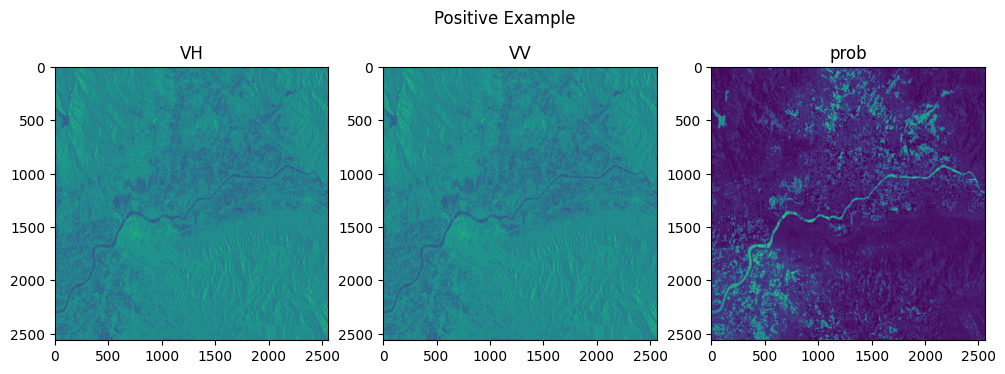

In [ ]:

  plt.figure(figsize=(12, 4))
  plt.subplot(131)
  plt.imshow(tmp_feed[0, 0].numpy())
  plt.title("VH")
  plt.subplot(132)
  plt.imshow(tmp_feed[0, 1].numpy())
  plt.title("VV")
  plt.subplot(133)
  plt.imshow(torch.nn.functional.softmax(output, dim=1).numpy()[0, 1])
  plt.title("prob")
  plt.suptitle("Positive Example")

Text(0.5, 0.98, 'Negative Examples')

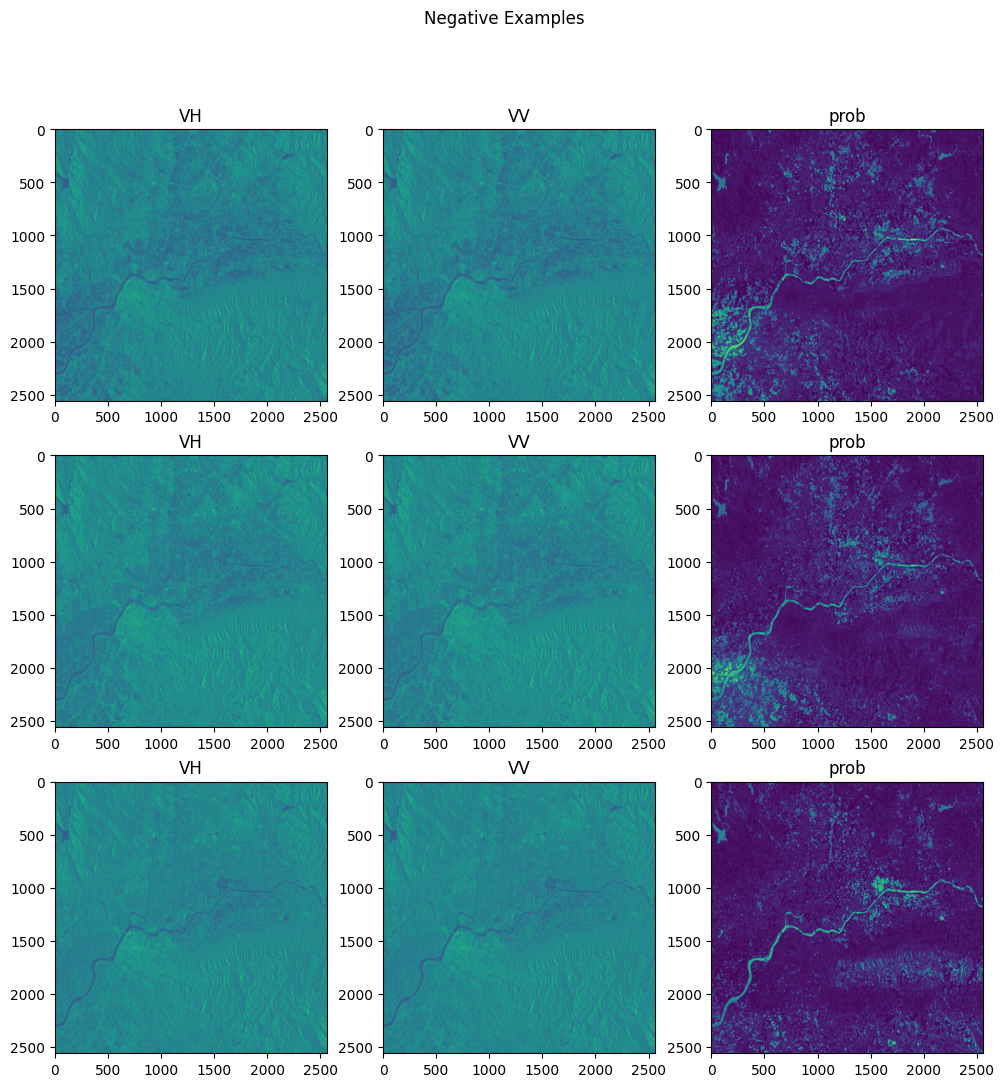

In [ ]:

previous_orbits_fluid_prob = torch.nn.functional.softmax(previous_orbits_output, dim=1)[:, 1, ...]
plt.figure(figsize=(12, 12))
for i in range(3):
  plt.subplot(3,3,3*i+1)
  plt.imshow(previous_orbits_feed[i, 0].numpy())
  plt.title("VH")
  plt.subplot(3,3,3*i+2)
  plt.imshow(previous_orbits_feed[i, 1].numpy())
  plt.title("VV")
  plt.subplot(3,3,3*i+3)
  plt.imshow(previous_orbits_fluid_prob[i].numpy())
  plt.title("prob")
plt.suptitle("Negative Examples")

Text(0.5, 1.0, '')

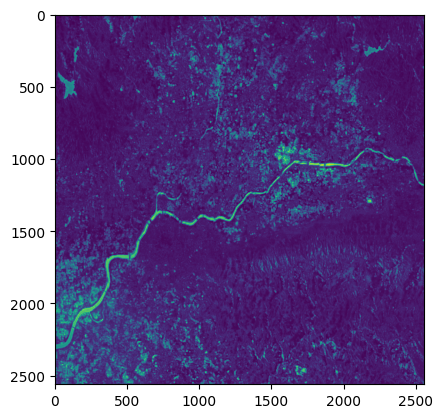

In [ ]:
plt.imshow(previous_orbits_fluid_prob.mean(dim=0))
plt.title("")

In [ ]:
vmin=previous_orbits_fluid_prob.min()
vmax=previous_orbits_fluid_prob.max()

Text(0.5, 1.0, 'Last Mean Orbit')

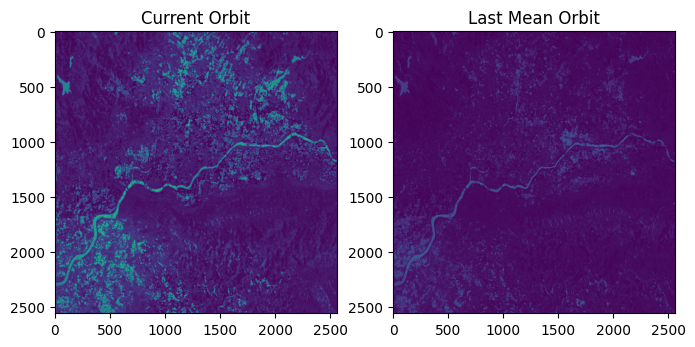

In [ ]:

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(torch.nn.functional.softmax(output, dim=1).numpy()[0, 1], vmin=0, vmax=0.5)
plt.title("Current Orbit")
plt.subplot(122)
#plt.imshow(torch.nn.functional.softmax(output, dim=1).numpy()[1, 1], vmin=0, vmax=0.5)
plt.imshow(previous_orbits_fluid_prob.mean(dim=0).numpy(), vmin=0, vmax=1)
plt.title("Last Mean Orbit")

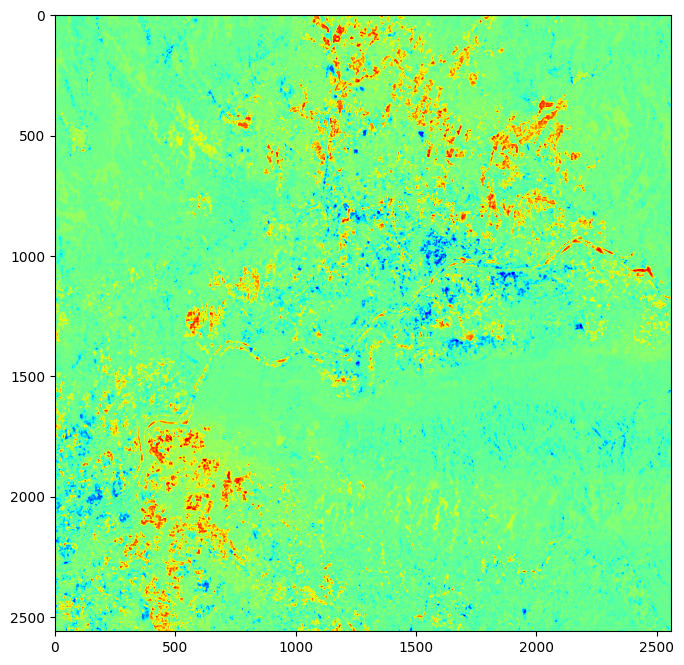

In [ ]:
p_diff = torch.nn.functional.softmax(output, dim=1).numpy()[0, 1] - previous_orbits_fluid_prob.mean(dim=0).numpy()

plt.figure(figsize=(8, 8))
plt.imshow(p_diff, cmap='jet')

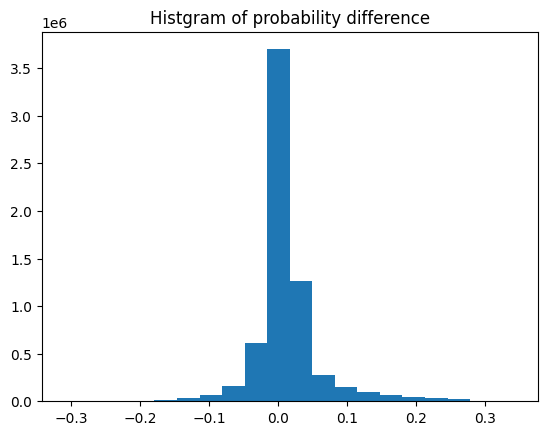

In [ ]:
plt.hist(p_diff.ravel(), bins=20);
plt.title("Histgram of probability difference");

In [ ]:
old_output = output

Text(0.5, 1.0, 'Last Mean Orbit')

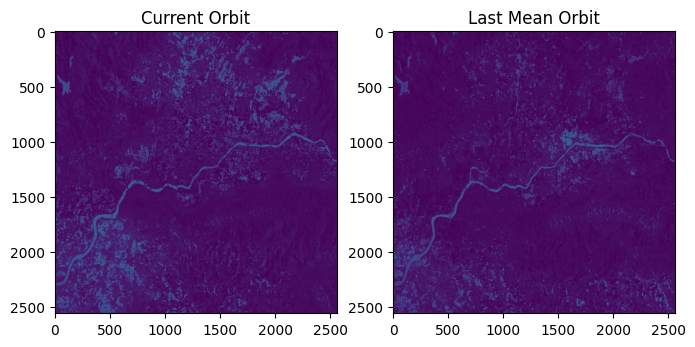

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(torch.nn.functional.softmax(old_output, dim=1).numpy()[0, 1], vmin=0, vmax=1)
plt.title("Current Orbit")
plt.subplot(122)
plt.imshow(torch.nn.functional.softmax(old_output, dim=1).numpy()[1, 1], vmin=0, vmax=1)
plt.title("Last Mean Orbit")

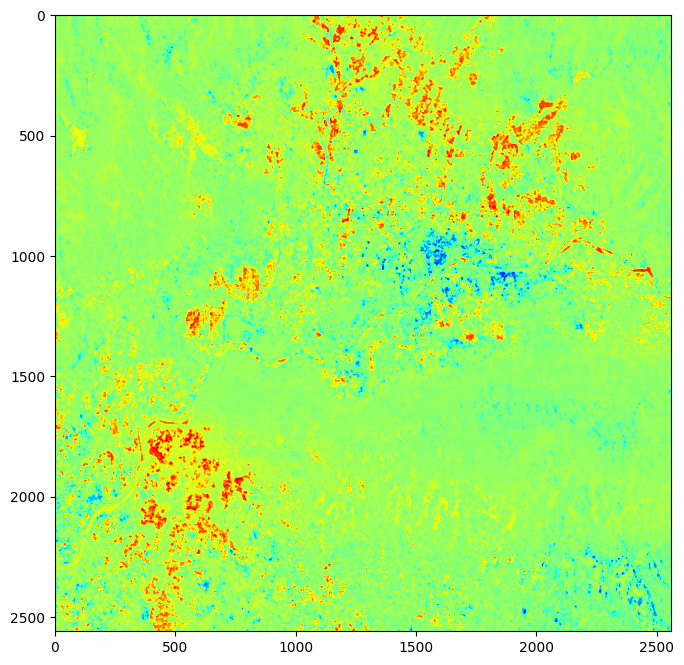

In [ ]:
p_diff = torch.nn.functional.softmax(output, dim=1).numpy()[0, 1] - torch.nn.functional.softmax(output, dim=1).numpy()[1, 1]

plt.figure(figsize=(8, 8))
plt.imshow(p_diff, cmap='jet')

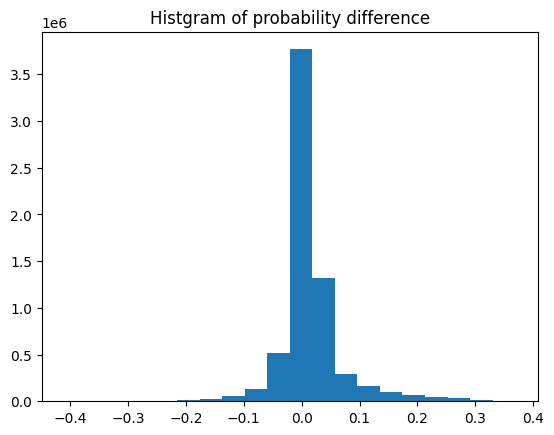

In [ ]:
plt.hist(p_diff.ravel(), bins=20);
plt.title("Histgram of probability difference");

Text(0.5, 1.0, 'vv input, flood area ratio: 1.70%')

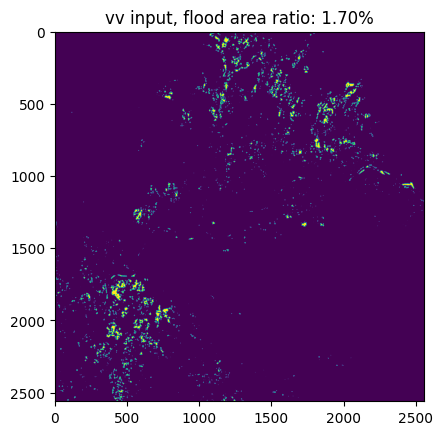

In [ ]:
threshold = 0.2

plt.imshow(p_diff > threshold)
plt.title(f"vv input, flood area ratio: {(100 * (p_diff > threshold).sum() / p_diff.ravel().shape).item():1.2f}%")

In [ ]:
torch.save(output, file_prb)
np.save(file_fldbbox , boundbox)